In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("ggplot")

import re
import nltk

from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer, CountVectorizer
from nltk import sent_tokenize, word_tokenize
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, make_scorer

from time import time
import pickle

In [33]:
df = pd.read_csv("dataset.csv")

In [34]:

df.head()

,headline,label
0,"You are so pathetic, just disappear.",-1
1,"No one likes you, stop trying.",-1
2,You’ll never be good at anything.,-1
3,"Everyone hates you, loser.",-1
4,"Just quit, you’re worthless.",-1


In [35]:
df['label'].unique()

array([-1,  0], dtype=int64)

Dataframe manipulation


In [36]:
def perform_data_manipulation():
    df = pd.read_csv("dataset.csv")
    
    for index in df.index:
        if df.loc[index, "label"]==-1:
            df.loc[index, "label"] = 1
    return df

In [37]:
df = perform_data_manipulation()

In [38]:
df.head()

,headline,label
0,"You are so pathetic, just disappear.",1
1,"No one likes you, stop trying.",1
2,You’ll never be good at anything.,1
3,"Everyone hates you, loser.",1
4,"Just quit, you’re worthless.",1


In [39]:
df['label'].unique()

array([1, 0], dtype=int64)

In [40]:
df.shape[0]

18150

Classification using Pie Chart

In [41]:
def performdatadistribution(df):
    total = df.shape[0]
    num_non_toxic = df[df['label']==0].shape[0]
    
    slices = [num_non_toxic/total, (total-num_non_toxic)/total]
    
    labeling = ['Non-Toxic', 'Toxic']
    
    explode = [0.2, 0]
    
    plt.pie(slices, explode = explode, shadow=True, autopct="%1.1f%%", labels = labeling, wedgeprops={'edgecolor': 'black'})
    
    plt.title('Number of Toxic Vs Non- Toxic Test Sample')
    
    plt.tight_layout()
    
    plt.show()

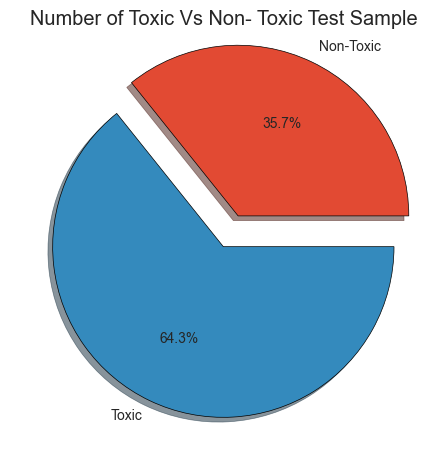

In [42]:
performdatadistribution(df)

In [43]:
def remove_pattern(input_txt, pattern):
    if (type(input_txt)==str):
        r = re.findall(pattern, input_txt)
        for i in r:
            input_txt = re.sub(i, '', input_txt)
        return input_txt
    else:
        return ""

In [44]:
df.head(1)

,headline,label
0,"You are so pathetic, just disappear.",1


In [45]:
def datasetCleaning(df):
    # Add a column for the length of the headlines
    df['length_headline'] = df['headline'].str.len()
    
    # Combine the dataframe with itself
    combined_df = pd.concat([df, df], ignore_index=True)
    
    # Remove @user patterns
    combined_df['tidy_tweet'] = np.vectorize(remove_pattern)(combined_df['headline'], "@[\w]*")
    
    # Remove non-alphabetic characters
    combined_df['tidy_tweet'] = combined_df['tidy_tweet'].str.replace("[^a-zA-Z#]", " ", regex=True)
    
    # Remove all words with length less than 3
    combined_df['tidy_tweet'] = combined_df['tidy_tweet'].apply(lambda x: ' '.join([w for w in x.split() if len(w) > 3]))
    
    # Add a column for the length of the cleaned tweets
    combined_df['length_tidy_tweet'] = combined_df['tidy_tweet'].str.len()
    
    # Tokenize the tweets
    tokenized_tweet = combined_df['tidy_tweet'].apply(lambda x: x.split())
    
    # Download NLTK WordNet data (if not already downloaded)
    nltk.download('wordnet')
    
    # Lemmatize tokens
    lemmatizer = nltk.stem.WordNetLemmatizer()
    tokenized_tweet = tokenized_tweet.apply(lambda x: [lemmatizer.lemmatize(i) for i in x])
    
    # Join tokens back into sentences
    tokenized_tweet = tokenized_tweet.apply(lambda x: ' '.join(x))
    combined_df['tidy_tweet'] = tokenized_tweet
    
    return combined_df, df

In [46]:
# Call the function
combined_df, df = datasetCleaning(df)

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\acer\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [47]:
combined_df.head()

,headline,label,length_headline,tidy_tweet,length_tidy_tweet
0,"You are so pathetic, just disappear.",1,36,pathetic just disappear,23
1,"No one likes you, stop trying.",1,30,like stop trying,17
2,You’ll never be good at anything.,1,33,never good anything,19
3,"Everyone hates you, loser.",1,26,Everyone hate loser,20
4,"Just quit, you’re worthless.",1,28,Just quit worthless,19


Dataset Splitting

In [48]:
from sklearn.model_selection import train_test_split

In [49]:
def performdatasplit(x, y, combined_df, df):
    X_train, X_test, y_train, y_test = train_test_split(combined_df['tidy_tweet'], combined_df['label'], test_size = x, random_state = y)
    print(f"Number of rows in the total dataset: {combined_df.shape[0]}")
    print(f"Number of rows in the train dataset: {X_train.shape[0]}")
    print(f"Number of rows in the test dataset: {X_test.shape[0]}")
    
    files = open("stopwords.txt" , "r")
    content = files.read()
    content_list = content.split("\n")
    files.close()
    
    tfidfvector = TfidfVectorizer(stop_words=content_list, lowercase=True)
    
    training_data = tfidfvector.fit_transform(X_train.values.astype('U'))
    
    testing_data = tfidfvector.transform(X_test.values.astype('U'))
    
    filename = 'tfidfvectoizer.pkl'
    
    pickle.dump(tfidfvector.vocabulary_, open(filename, 'wb'))
    
    return X_train , X_test, y_train, y_test, testing_data, filename, training_data, content_list

In [50]:
X_train , X_test, y_train, y_test, testing_data, filename, training_data, content_list = performdatasplit(0.2, 42, combined_df, df)

Number of rows in the total dataset: 36300
Number of rows in the train dataset: 29040
Number of rows in the test dataset: 7260


C:\Python311\Lib\site-packages\sklearn\feature_extraction\text.py:406: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ninad'] not in stop_words.
  warnings.warn(


Apply Machine Learning Algorithm

In [51]:
import xgboost as xgb
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, BaggingClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier

In [52]:
def pipeline(X_train, y_train, X_test, y_test):
    MODELS = [LinearSVC(), LogisticRegression(), MultinomialNB(), DecisionTreeClassifier(),
              AdaBoostClassifier(), BaggingClassifier(), SGDClassifier()]
    
    size = len(y_train)
    
    results = {}
    
    final_result = []
    
    for model in MODELS:
        results['Algorithm'] = model.__class__.__name__
        
        start = time()
        print(f"Training Time : {model.__class__.__name__}")
        model.fit(X_train, y_train)
        end = time()
        
        filename = model.__class__.__name__+".pkl"
        pickle.dump(model, open(filename, "wb"))
        
        results['Training Time'] = end - start
        
        start = time()
        prediction_test = model.predict(X_test)
        prediction_train = model.predict(X_train)
        end = time()
        
        results['Prediction Time'] = end - start
        
        results['Accuracy : Test'] = accuracy_score(y_test, prediction_test)
        results['Accuracy : Train'] = accuracy_score(y_train, prediction_train)
        
        results['F1 Score : Test'] = f1_score(y_test, prediction_test, average='weighted')
        results['F1 Score : Train'] = f1_score(y_train, prediction_train, average='weighted')
        
        results['Precision : Test'] = precision_score(y_test, prediction_test, average='weighted')
        results['Precision : Train'] = precision_score(y_train, prediction_train, average='weighted')
        
        results['Recall : Test'] = recall_score(y_test, prediction_test, average='weighted')
        results['Recall : Train'] = recall_score(y_train, prediction_train, average='weighted')
        
        print(f"Training {model.__class__.__name__} finished in {results['Training Time']} sec")
        
        final_result.append(results.copy())
    return final_result


In [53]:

final_result = pipeline(training_data, y_train, testing_data, y_test)

Training Time : LinearSVC
Training LinearSVC finished in 0.17549657821655273 sec
Training Time : LogisticRegression
Training LogisticRegression finished in 0.5117976665496826 sec
Training Time : MultinomialNB
Training MultinomialNB finished in 0.014039754867553711 sec
Training Time : DecisionTreeClassifier
Training DecisionTreeClassifier finished in 11.636869192123413 sec
Training Time : AdaBoostClassifier


C:\Python311\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Training AdaBoostClassifier finished in 7.524925947189331 sec
Training Time : BaggingClassifier
Training BaggingClassifier finished in 104.85582041740417 sec
Training Time : SGDClassifier
Training SGDClassifier finished in 0.08571004867553711 sec


In [54]:
def performfinalresult(final_results):
    results = pd.DataFrame(final_results)
    results.reindex(columns = ['Algorithm', 'Accuracy : Test', 'Precision : Test', 'Recall : Test', 'F1 Score : Test', 'Prediction Time',
                          'Accuracy : Train', 'Precision : Train', 'Recall : Train', 'F1 Score : Train', 'Training Time'])
    results.sort_values(by = 'F1 Score : Test', inplace=True, ascending=False)
    
    return results

In [55]:
results = performfinalresult(final_result)
results.reset_index(drop = True)

,Algorithm,Training Time,Prediction Time,Accuracy : Test,Accuracy : Train,F1 Score : Test,F1 Score : Train,Precision : Test,Precision : Train,Recall : Test,Recall : Train
0,DecisionTreeClassifier,11.636869,0.075253,0.973691,0.996247,0.973697,0.996244,0.973704,0.996251,0.973691,0.996247
1,BaggingClassifier,104.855820,0.871345,0.969284,0.994525,0.969335,0.994522,0.969447,0.994524,0.969284,0.994525
2,LinearSVC,0.175497,0.003282,0.963085,0.986777,0.963136,0.986786,0.963228,0.986805,0.963085,0.986777
3,LogisticRegression,0.511798,0.003204,0.938017,0.959366,0.938022,0.959340,0.938028,0.959323,0.938017,0.959366
4,SGDClassifier,0.085710,0.004408,0.932645,0.953960,0.932995,0.954091,0.933949,0.954410,0.932645,0.953960
5,MultinomialNB,0.014040,0.008046,0.900275,0.926171,0.898311,0.925046,0.901647,0.927600,0.900275,0.926171
6,AdaBoostClassifier,7.524926,1.416489,0.823829,0.825310,0.827676,0.828883,0.865229,0.867162,0.823829,0.825310


In [56]:
results.describe().loc[['min', 'max'], :]

,Training Time,Prediction Time,Accuracy : Test,Accuracy : Train,F1 Score : Test,F1 Score : Train,Precision : Test,Precision : Train,Recall : Test,Recall : Train
min,0.01404,0.003204,0.823829,0.825310,0.827676,0.828883,0.865229,0.867162,0.823829,0.825310
max,104.85582,1.416489,0.973691,0.996247,0.973697,0.996244,0.973704,0.996251,0.973691,0.996247


Summary in Graph

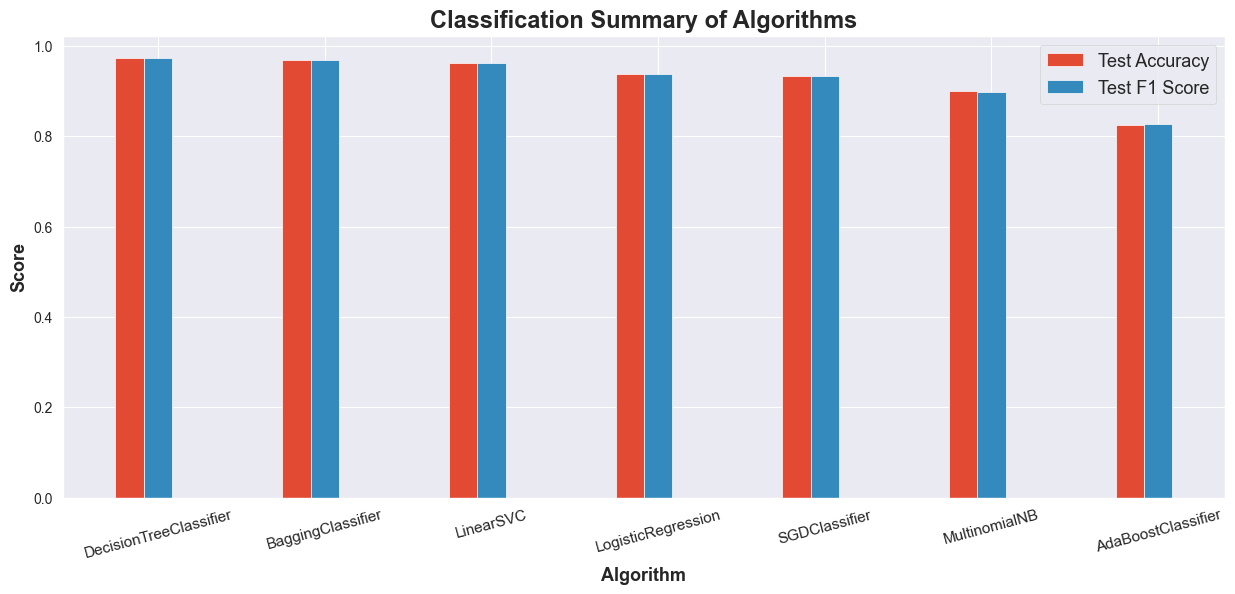

In [57]:
best_acc = results[results['Accuracy : Test'] == results['Accuracy : Test'].max()]
best_f1 = results[results['F1 Score : Test'] == results['F1 Score : Test'].max()]
best_precision = results[results['Precision : Test'] == results['Precision : Test'].max()]
best_recall = results[results['Recall : Test'] == results['Recall : Test'].max()]

sns.set_style('darkgrid')
plt.figure(figsize = (15, 6))

barWidth = 0.17
 
# set height of bar
bars1 = results['Accuracy : Test']
bars2 = results['F1 Score : Test']

# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]

# Make the plot
pal = sns.color_palette()
plt.bar(r1, bars1, color= pal[0], width=barWidth, edgecolor='white', label='Test Accuracy')
plt.bar(r2, bars2, color= pal[1], width=barWidth, edgecolor='white', label='Test F1 Score')

# Add xticks on the middle of the group bars
plt.xlabel('Algorithm', fontweight='bold', fontsize = 13)
plt.ylabel('Score', fontweight = 'bold', fontsize = 13)
plt.xticks([r + barWidth for r in range(len(bars1))], results['Algorithm'], rotation = 15, fontsize = 11)
 
# Create legend & Show graphic
plt.legend(fontsize = 13)

textstr = '\n'.join(['Best Accuracy: {:.3f} - {}'.format(best_acc['Accuracy : Test'].values[0], best_acc['Algorithm'].values[0]), 
                     'Best F1 Score: {:.3f} - {}'.format(best_f1['F1 Score : Test'].values[0], best_f1['Algorithm'].values[0])])
props = dict(boxstyle='round', facecolor='lightgrey', alpha=0.5)

plt.title('Classification Summary of Algorithms', fontweight = 'bold', fontsize = 17);

Training and Prediction time of Algorithm

Text(0.5, 1.0, 'Training and Prediction time of Algorithms')

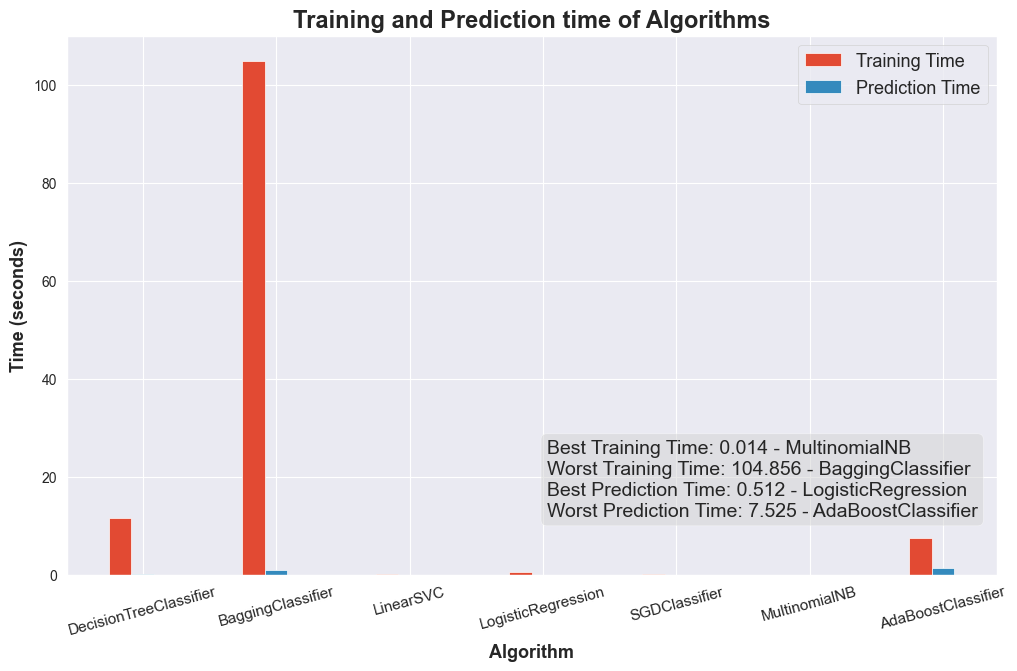

In [58]:
best_train_time = results[results['Training Time'] == results['Training Time'].min()]
worst_train_time = results[results['Training Time'] == results['Training Time'].max()]
best_prediction_time = results[results['Prediction Time'] == results['Prediction Time'].min()]
worst_prediction_time = results[results['Prediction Time'] == results['Prediction Time'].max()]

plt.figure(figsize = (12, 7))

barWidth = 0.17
 
# set height of bar
bars1 = results['Training Time']
bars2 = results['Prediction Time']
 
# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
 
# Make the plot
plt.bar(r1, bars1, color= pal[0], width=barWidth, edgecolor='white', label='Training Time')
plt.bar(r2, bars2, color= pal[1], width=barWidth, edgecolor='white', label='Prediction Time')
 
# Add xticks on the middle of the group bars
plt.xlabel('Algorithm', fontweight='bold', fontsize = 13)
plt.ylabel('Time (seconds)', fontweight = 'bold', fontsize = 13)
plt.xticks([r + barWidth for r in range(len(bars1))], results['Algorithm'], rotation = 15, fontsize = 11)


textstr = '\n'.join(('Best Training Time: {:.3f} - {}'.format(best_train_time['Training Time'].values[0], best_train_time['Algorithm'].values[0]), 
                     'Worst Training Time: {:.3f} - {}'.format(worst_train_time['Training Time'].values[0], worst_train_time['Algorithm'].values[0]),
                   'Best Prediction Time: {:.3f} - {}'.format(best_prediction_time['Training Time'].values[0], best_prediction_time['Algorithm'].values[0]), 
                    'Worst Prediction Time: {:.3f} - {}'.format(worst_prediction_time['Training Time'].values[0], worst_prediction_time['Algorithm'].values[0])))
props = dict(boxstyle='round', facecolor='lightgrey', alpha=0.5)

#place a text box
plt.text(3.2, 12, textstr, fontsize=14,  bbox=props) 

# Create legend & Show graphic
plt.legend(fontsize = 13)
plt.title('Training and Prediction time of Algorithms', fontweight = 'bold', fontsize = 17)

In [59]:

df.head()

,headline,label,length_headline
0,"You are so pathetic, just disappear.",1,36
1,"No one likes you, stop trying.",1,30
2,You’ll never be good at anything.,1,33
3,"Everyone hates you, loser.",1,26
4,"Just quit, you’re worthless.",1,28


In [60]:
data = ["you are a loser"]

tfidf_vector = TfidfVectorizer(stop_words=content_list, lowercase=True, vocabulary=pickle.load(open("tfidfvectoizer.pkl", "rb")))
preprocessed_data = tfidf_vector.fit_transform(data)

trained_model = pickle.load(open('LinearSVC.pkl', 'rb'))
print(trained_model.predict(preprocessed_data))

if(trained_model.predict(preprocessed_data)==1):
    print("bullying")
else:
    print("non-bullying")

[1]
bullying


C:\Python311\Lib\site-packages\sklearn\feature_extraction\text.py:406: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ninad'] not in stop_words.
  warnings.warn(


Fine Tuining

In [61]:
from sklearn.model_selection import GridSearchCV

def tuining(clf, param_dict, X_train, y_train, X_test, y_test):
    scorer = make_scorer(f1_score)
    
    grid_obj = GridSearchCV(estimator=clf, param_grid=param_dict, scoring=scorer, cv=5)
    
    grid_fit = grid_obj.fit(X_train, y_train)
    
    best_clf = grid_fit.best_estimator_
    
    prediction = (clf.fit(X_train, y_train)).predict(X_test)
    
    best_prediction = best_clf.predict(X_test)
    
    print(clf.__class__.__name__)
    print(f"Best Parameter:  {grid_fit.best_params_}")
    
    print(f"Accuracy:  {accuracy_score(y_test, best_prediction)}")

    print(f"F1 Score :  {f1_score(y_test, best_prediction)}")
    
    print(f"Precision :  {precision_score(y_test, best_prediction)}")
    
    print(f"Recall:  {recall_score(y_test, best_prediction)}")

In [62]:
param_grid = {
    'C': [0.25, 0.5, 0.75, 1, 1.2]
}

clf_model = LinearSVC()

tuining(clf_model, param_grid, training_data, y_train, testing_data, y_test)

LinearSVC
Best Parameter:  {'C': 1.2}
Accuracy:  0.9637741046831956
F1 Score :  0.9718746658111432
Precision :  0.975107296137339
Recall:  0.9686633979961629


In [63]:
pickle.dump(clf_model, open("LinearSVCTuned.pkl", "wb"))